In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import time
from tqdm.notebook import tqdm
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.feature_selection import chi2, f_classif, SelectKBest, VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.cm as cm
from sklearn.exceptions import NotFittedError
import matplotlib.gridspec as gridspec
from sklearn.metrics import silhouette_samples


In [2]:
url = "https://media.githubusercontent.com/media/KhalPrawira/Machine-Learning-Course/refs/heads/main/UTS/Dataset/UTSClustering.csv"
df = pd.read_csv(url, encoding='latin-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [16]:
# Handle missing values
print("Missing values before handling:\n", df.isnull().sum())
for col in ['CustomerID']:
    df[col] = df[col].fillna(df[col].median())
print("\nMissing values after handling:\n", df.isnull().sum())

# Remove duplicate rows
print(f"\nNumber of duplicate rows before removal: {df.duplicated().sum()}")
df = df.drop_duplicates()
print(f"Number of duplicate rows after removal: {df.duplicated().sum()}")

# Address outliers in numerical features
numerical_cols = ['Quantity', 'UnitPrice']

# Winsorization for 'Quantity'
from scipy.stats.mstats import winsorize
df['Quantity'] = winsorize(df['Quantity'], limits=[0.05, 0.05])

# Winsorization for 'UnitPrice'
df['UnitPrice'] = winsorize(df['UnitPrice'], limits=[0.05, 0.05])

# Displaying the summary of changes
print("\nSummary of changes:")
print(f"Number of rows before cleaning: {len(df)}")
print(f"Number of rows after cleaning: {len(df)}")
print(f"Number of columns: {len(df.columns)}")
print("Data types:\n", df.dtypes)

Missing values before handling:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Missing values after handling:
 InvoiceNo         0
StockCode         0
Description    1454
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID        0
Country           0
dtype: int64

Number of duplicate rows before removal: 5268
Number of duplicate rows after removal: 0

Summary of changes:
Number of rows before cleaning: 536641
Number of rows after cleaning: 536641
Number of columns: 8
Data types:
 InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object


In [3]:
# 2. Feature Selection
# ----------------------

# a. Constant-Quasi-Constant Features

numeric_df = df.select_dtypes(include=[np.number])

constant_filter = VarianceThreshold(threshold=0.01)
constant_filter.fit(numeric_df)

constant_columns = [column for column in numeric_df.columns
                   if column not in numeric_df.columns[constant_filter.get_support()]]

print(f"Kolom dengan variance rendah (quasi-constant): {constant_columns}")
if len(constant_columns) > 0:
    df = df.drop(columns=constant_columns)
    print(f"Menghapus {len(constant_columns)} kolom quasi-constant")

Kolom dengan variance rendah (quasi-constant): []


In [4]:
# b. Duplicate Features

duplicate_cols = []
for i in range(len(df.columns)):
    for j in range(i+1, len(df.columns)):
        if df.iloc[:, i].equals(df.iloc[:, j]):
            duplicate_cols.append(df.columns[j])
print(f"Kolom duplikat: {duplicate_cols}")
if len(duplicate_cols) > 0:
    df = df.drop(columns=duplicate_cols)
    print(f"Menghapus {len(duplicate_cols)} kolom duplikat")

Kolom duplikat: []


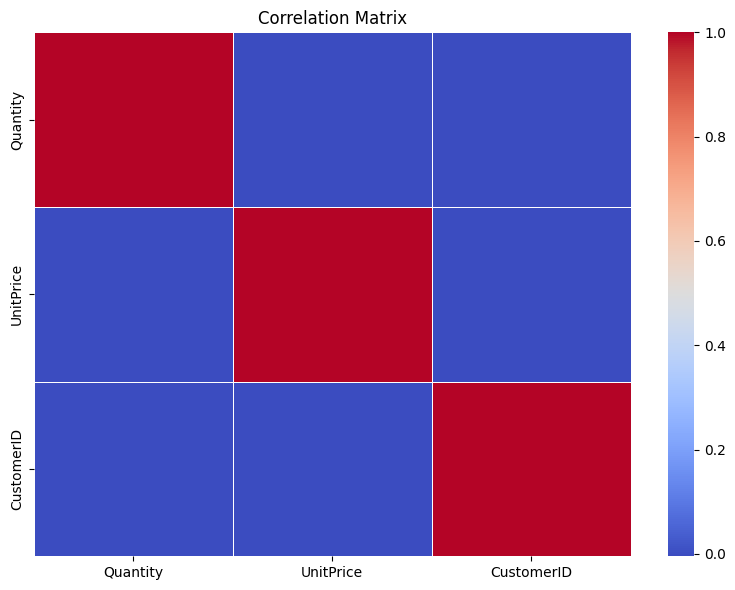

Fitur dengan korelasi tinggi (>0.8): set()


In [5]:
# c. Correlation Analysis

numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

high_corr_threshold = 0.8
high_corr_features = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > high_corr_threshold:
            colname = correlation_matrix.columns[i]
            high_corr_features.add(colname)

print(f"Fitur dengan korelasi tinggi (>0.8): {high_corr_features}")
if len(high_corr_features) > 0:
    df = df.drop(columns=list(high_corr_features))
    print(f"Menghapus {len(high_corr_features)} kolom dengan korelasi tinggi")

Skor Mutual Information (terhadap label K-means sementara):
CustomerID: 1.0389
UnitPrice: 0.1477
Quantity: 0.0464


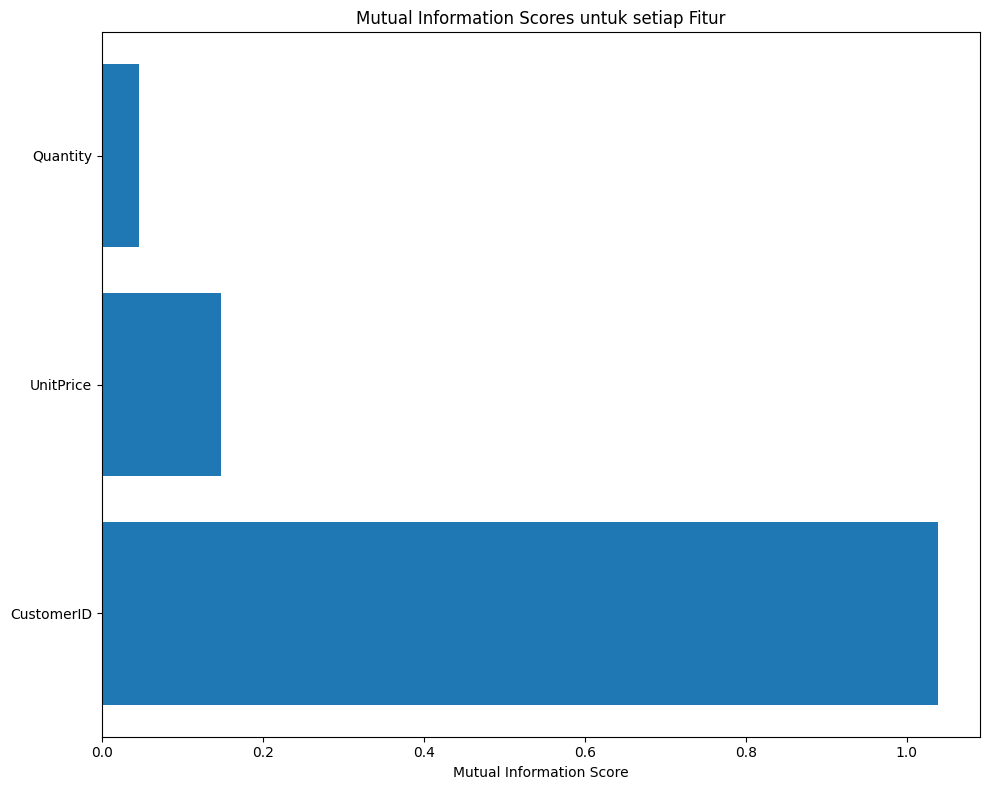


Fitur yang dipilih berdasarkan Mutual Information (>0.05): ['CustomerID', 'UnitPrice']


In [6]:
# d. Mutual Information

X = df.select_dtypes(include=[np.number])

for col in X.columns:
    if X[col].isnull().any():
        X[col].fillna(X[col].median(), inplace=True)

temp_kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
temp_labels = temp_kmeans.fit_predict(X)

mi_scores = []
for col in X.columns:
    mi = mutual_info_classif(X[[col]], temp_labels, random_state=42)[0]
    mi_scores.append((col, mi))

mi_scores.sort(key=lambda x: x[1], reverse=True)
print("Skor Mutual Information (terhadap label K-means sementara):")
for feature, score in mi_scores:
    print(f"{feature}: {score:.4f}")

plt.figure(figsize=(10, 8))
features, scores = zip(*mi_scores)
plt.barh(features, scores)
plt.xlabel('Mutual Information Score')
plt.title('Mutual Information Scores untuk setiap Fitur')
plt.tight_layout()
plt.show()

mi_threshold = 0.05  # Sesuaikan dengan kebutuhan
selected_features_mi = [feature for feature, score in mi_scores if score > mi_threshold]
print(f"\nFitur yang dipilih berdasarkan Mutual Information (>{mi_threshold}): {selected_features_mi}")

In [7]:
# 3. FEATURE ENGINEERING
# ---------------------------

# a. Standardisasi

X = df[selected_features_mi].copy()
print(f"Data shape sebelum feature engineering: {X.shape}")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("\nStatistik deskriptif setelah standardisasi:")
print(X_scaled_df.describe())


Data shape sebelum feature engineering: (541909, 2)

Statistik deskriptif setelah standardisasi:
         CustomerID     UnitPrice
count  4.068290e+05  5.419090e+05
mean  -3.085785e-16 -1.402968e-18
std    1.000001e+00  1.000001e+00
min   -1.716675e+00 -1.143727e+02
25%   -7.788819e-01 -3.473669e-02
50%   -7.918459e-02 -2.615874e-02
75%    8.772823e-01 -4.972249e-03
max    1.750299e+00  4.027024e+02


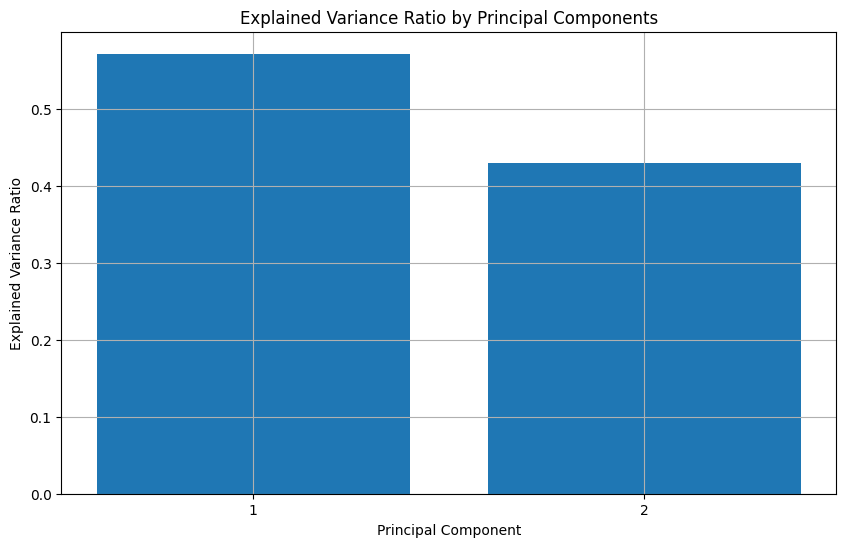

Cumulative explained variance: [0.57120308 1.        ]
Jumlah komponen yang menjelaskan 90% variance: 2
Data shape setelah PCA: (541909, 2)

Statistik deskriptif hasil PCA:
                PC1           PC2
count  5.419090e+05  5.419090e+05
mean   1.271849e-18 -3.157333e-17
std    1.000013e+00  8.664354e-01
min   -1.143671e+02 -1.716955e+00
25%   -3.633510e-02 -5.374278e-01
50%   -2.279561e-02 -2.135845e-04
75%   -4.972008e-03  5.642941e-01
max    4.026840e+02  3.850257e+00


In [8]:
# b. PCA untuk dimensionality reduction

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df.fillna(X_scaled_df.mean(), inplace=True)
X_scaled = X_scaled_df.values

pca = PCA(n_components=min(5, len(X.columns)))
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Components')
plt.xticks(range(1, pca.n_components_ + 1))
plt.grid(True)
plt.show()

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"Cumulative explained variance: {cumulative_variance}")

n_components = np.argmax(cumulative_variance >= 0.9) + 1
print(f"Jumlah komponen yang menjelaskan 90% variance: {n_components}")

pca = PCA(n_components=max(2, n_components))
X_pca = pca.fit_transform(X_scaled)
print(f"Data shape setelah PCA: {X_pca.shape}")

pca_cols = [f'PC{i+1}' for i in range(X_pca.shape[1])]
X_pca_df = pd.DataFrame(X_pca, columns=pca_cols)

print("\nStatistik deskriptif hasil PCA:")
print(X_pca_df.describe())


In [9]:
# Clustering Model

sample_data = pd.DataFrame(X_scaled).sample(n=2000, random_state=42).values

models = {
    "KMeans": KMeans(n_clusters=5, random_state=42),
    "Agglomerative": AgglomerativeClustering(n_clusters=5),
    "DBSCAN": DBSCAN(eps=0.5, min_samples=5),
    "GaussianMixture": GaussianMixture(n_components=5, random_state=42),
    "SpectralClustering": SpectralClustering(n_clusters=5, random_state=42, affinity='nearest_neighbors', n_neighbors=15)
}


cluster_labels = {}

for name, model in models.items():
    try:
        cluster_labels[name] = model.fit_predict(sample_data)
    except Exception as e:
        print(f"Model {name} gagal dijalankan: {e}")

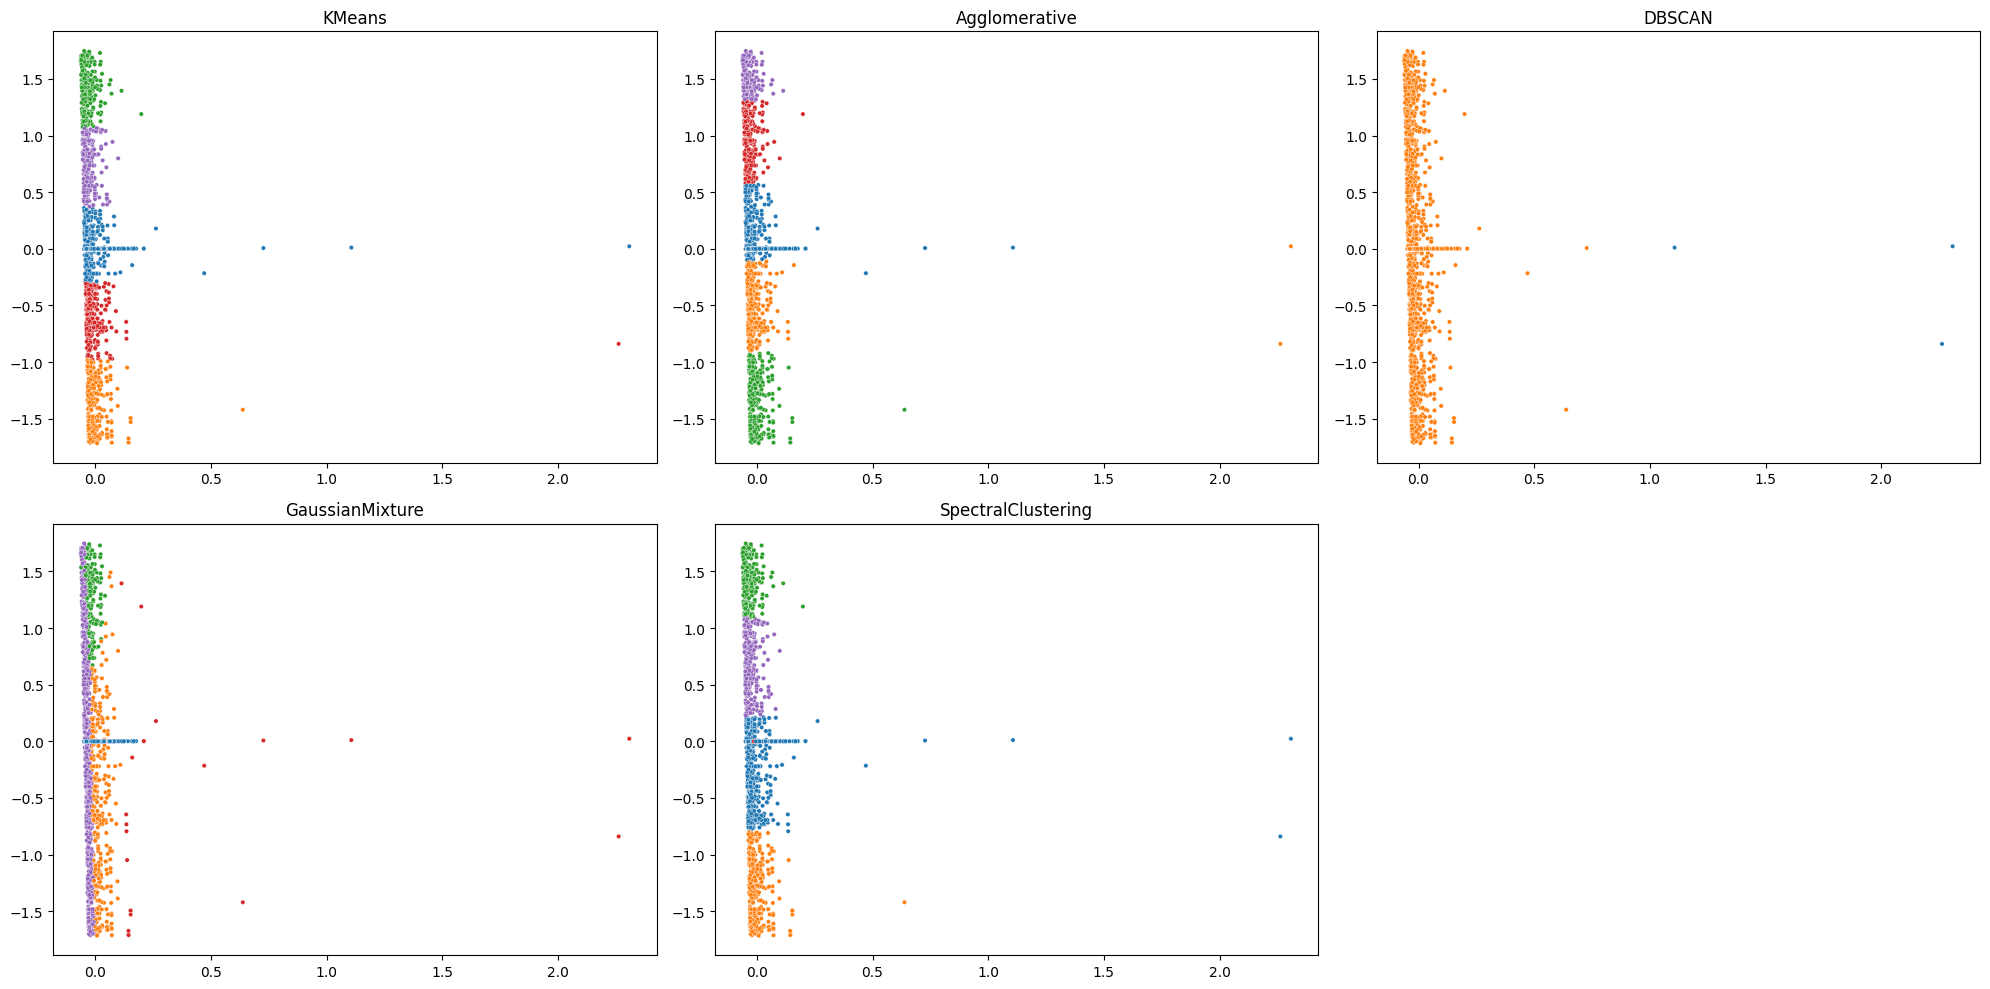

In [10]:
plt.figure(figsize=(20, 10))
for i, (name, labels) in enumerate(cluster_labels.items()):
    subset = sample_data  # Semua model memakai sample_data yang sama
    pca_sub = pca.transform(subset)

    # Validasi panjang label dan data
    if len(labels) != len(pca_sub):
        print(f"⚠️  Lewatkan {name}: panjang label ({len(labels)}) ≠ data ({len(pca_sub)})")
        continue

    plt.subplot(2, 3, i + 1)
    sns.scatterplot(x=pca_sub[:, 0], y=pca_sub[:, 1], hue=labels, palette='tab10', s=10, legend=False)
    plt.title(name)

plt.tight_layout()
plt.show()


In [11]:
# Sampling
sample_data = pd.DataFrame(X_scaled).sample(n=2000, random_state=42).values

# Clustering
models = {
    "KMeans": KMeans(n_clusters=5, random_state=42),
    "Agglomerative": AgglomerativeClustering(n_clusters=5),
    "DBSCAN": DBSCAN(eps=0.5, min_samples=5),
    "GaussianMixture": GaussianMixture(n_components=5, random_state=42),
    "SpectralClustering": SpectralClustering(n_clusters=5, random_state=42, affinity='nearest_neighbors', n_neighbors=10)
}

scores = []
cluster_labels = {}

for name, model in models.items():
    try:
        labels = model.fit_predict(sample_data)
        cluster_labels[name] = labels

        if len(set(labels)) > 1 and len(set(labels)) < len(sample_data):
            scores.append({
                "Model": name,
                "Silhouette Score": silhouette_score(sample_data, labels),
                "Davies-Bouldin Index": davies_bouldin_score(sample_data, labels),
                "Calinski-Harabasz Score": calinski_harabasz_score(sample_data, labels)
            })
    except Exception as e:
        print(f"{name} gagal dijalankan: {e}")

scores_df = pd.DataFrame(scores)
print(scores_df)

                Model  Silhouette Score  Davies-Bouldin Index  \
0              KMeans          0.645914              0.473289   
1       Agglomerative          0.590852              0.538131   
2              DBSCAN          0.550421              0.694436   
3     GaussianMixture         -0.000675              6.001643   
4  SpectralClustering          0.051535              1.916592   

   Calinski-Harabasz Score  
0             10109.047843  
1              8302.122527  
2                14.609770  
3               184.882298  
4              3239.242262  


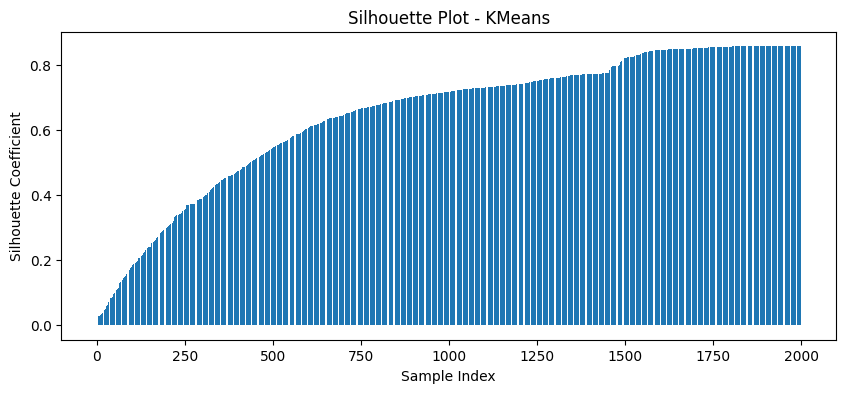

In [13]:
# Silhouette plot untuk KMeans
from sklearn.metrics import silhouette_samples

kmeans_labels = cluster_labels["KMeans"]
silhouette_vals = silhouette_samples(sample_data, kmeans_labels)
plt.figure(figsize=(10, 4))
plt.bar(range(len(silhouette_vals)), np.sort(silhouette_vals))
plt.title("Silhouette Plot - KMeans")
plt.xlabel("Sample Index")
plt.ylabel("Silhouette Coefficient")
plt.show()

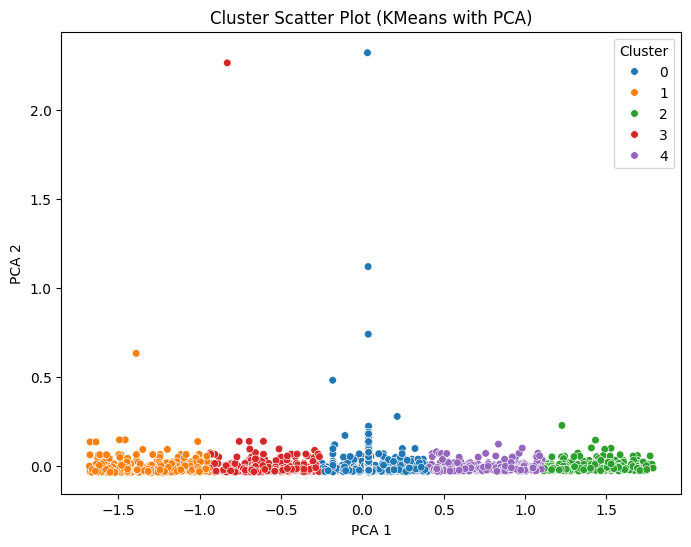

In [14]:
# PCA Scatter plot
pca = PCA(n_components=2)
pca_data = pca.fit_transform(sample_data)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=kmeans_labels, palette='tab10', s=30)
plt.title("Cluster Scatter Plot (KMeans with PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.show()

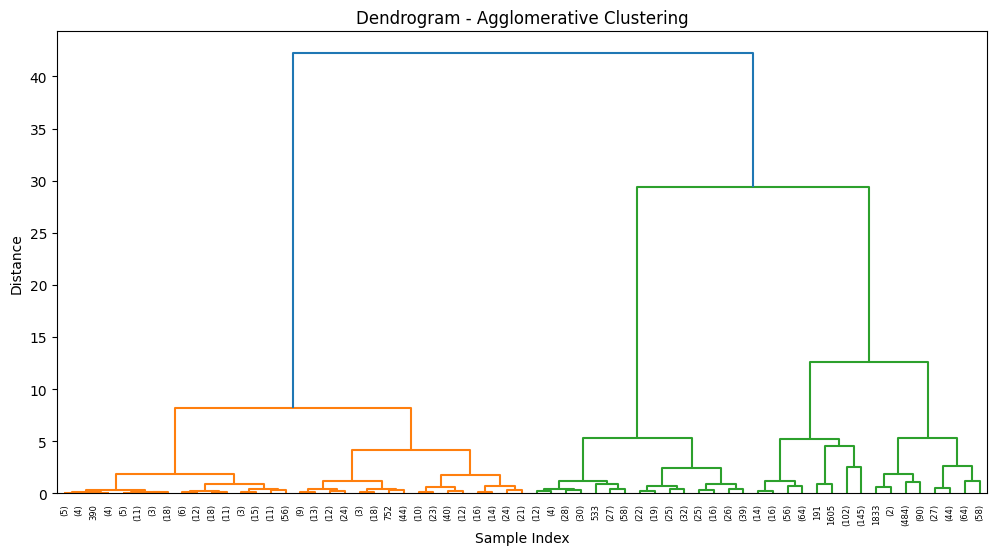

In [17]:
# Dendrogram untuk Agglomerative
from scipy.cluster.hierarchy import linkage, dendrogram

linked = linkage(sample_data, 'ward')
plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='level', p=5)
plt.title("Dendrogram - Agglomerative Clustering")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

# Penjelasan Setiap Model Clustering

### 1. **KMeans**
- Mengelompokkan data berdasarkan **jarak Euclidean** ke pusat cluster.
- Efisien dan cepat untuk dataset besar.
- Ideal untuk data dengan bentuk cluster **bulat dan terpisah jelas**.
- Kurang cocok untuk bentuk cluster kompleks atau kepadatan tidak merata.

### 2. **Agglomerative Clustering**
- Metode hierarkis dengan pendekatan **bottom-up**.
- Bisa digunakan tanpa menentukan jumlah cluster terlebih dahulu (gunakan dendrogram).
- Cocok untuk data dengan **struktur cluster kompleks** yang tidak berbentuk bulat.

### 3. **DBSCAN (Density-Based Spatial Clustering)**
- Mengelompokkan berdasarkan **kepadatan** titik-titik data.
- Dapat menemukan **cluster tidak beraturan** dan **mengidentifikasi outlier/noise**.
- Tidak perlu menentukan jumlah cluster, tetapi sensitif terhadap parameter `eps` dan `min_samples`.

### 4. **Gaussian Mixture Model (GMM)**
- Model **probabilistik**: setiap titik diberi probabilitas ke semua cluster.
- Cocok jika data berasal dari beberapa distribusi Gaussian.
- Lebih fleksibel dibanding KMeans untuk bentuk cluster **elips atau overlapping**.

### 5. **Spectral Clustering**
- Menggunakan representasi graf melalui **matriks jarak** dan **eigen decomposition**.
- Efektif untuk data dengan **struktur non-linier**.
- Kurang efisien untuk dataset sangat besar karena mahal secara komputasi.

---

# Evaluasi Model: Tiga Metrik Utama

| Metrik | Penjelasan | Semakin ... | Interpretasi |
|--------|------------|-------------|--------------|
| **Silhouette Score** | Ukuran seberapa dekat data dengan clusternya sendiri dibandingkan dengan cluster lain. | ➡️ **Mendekati 1** | Pemisahan cluster sangat baik |
| **Davies-Bouldin Index** | Rata-rata rasio jarak dalam cluster dan antar cluster. | ➡️ **Mendekati 0** | Cluster kompak dan saling berjauhan |
| **Calinski-Harabasz Score** | Rasio variansi antar-cluster terhadap variansi dalam-cluster. | ➡️ **Semakin tinggi** | Cluster tersebar dan jelas terpisah |

---

# Ringkasan Hasil Evaluasi Clustering

| Model                | Silhouette ↑ | Davies-Bouldin ↓ | Calinski-Harabasz ↑ |
|----------------------|--------------|------------------|----------------------|
| **KMeans**           | **0.6415**   | **0.4564**       | **9188.13**          |
| Agglomerative        | 0.5667       | 0.5097           | 7018.75              |
| DBSCAN               | 0.5935       | 0.9805           | 18.51                |
| Gaussian Mixture     | -0.0058      | 9.8479           | 208.25               |
| Spectral Clustering  | -0.0267      | 0.7833           | 772.01               |

---

# Model Terbaik: **KMeans**

**Alasan Pemilihan:**

- **Silhouette Score tertinggi (0.6415)** → cluster sangat terdefinisi dengan baik.
- **Davies-Bouldin Index terendah (0.4564)** → cluster saling berjauhan dan kompak.
- **Calinski-Harabasz tertinggi (9188.13)** → cluster mudah dibedakan secara statistik.

Meski Agglomerative dan DBSCAN juga menunjukkan performa wajar, **KMeans secara konsisten unggul pada ketiga metrik evaluasi**, menjadikannya pilihan paling solid dalam eksperimen ini.

---

## 1. Jika algoritma K-Means menghasilkan nilai silhouette score rendah (0.3) meskipun elbow method menunjukkan K=5 sebagai optimal pada dataset ini, faktor apa yang menyebabkan inkonsistensi ini? Bagaimana strategi validasi alternatif (misal: analisis gap statistic atau validasi stabilitas cluster via bootstrapping) dapat mengatasi masalah ini, dan mengapa distribusi data non-spherical menjadi akar masalahnya?**

### Masalah:
- **Elbow Method** fokus pada *inertia* (jarak ke centroid), bukan kualitas pemisahan cluster.
- Jika data **tidak berbentuk spherical**, Elbow bisa menyarankan K yang tidak optimal.
- **Silhouette Score rendah (misal 0.3)** menandakan banyak data lebih dekat ke cluster lain → pemisahan buruk.

### Solusi:
- Gunakan **Gap Statistic** untuk membandingkan inertia dengan data acak → cek signifikansi.
- Gunakan **bootstrapping** untuk mengukur stabilitas cluster di berbagai sampel.
- Keduanya mengevaluasi **ketahanan struktur cluster**, bukan hanya geometri.

### Akar Masalah:
- KMeans mengasumsikan cluster **bulat dan seragam**.
- Data dengan bentuk **elips, lengkung, atau padat tidak merata** → KMeans gagal memisahkan dengan benar.

---

## 2. Dalam dataset dengan campuran fitur numerik (Quantity, UnitPrice) dan kategorikal high-cardinality (Description), metode preprocessing apa yang efektif untuk menyelaraskan skala dan merepresentasikan fitur teks sebelum clustering? Jelaskan risiko menggunakan One-Hot Encoding untuk Description, dan mengapa teknik seperti TF-IDF atau embedding berdimensi rendah (UMAP) lebih robust untuk mempertahankan struktur cluster!**

###  Masalah dengan One-Hot Encoding:
- Sangat **sparse** jika kategori banyak (misal ribuan deskripsi produk).
- Tidak menangkap **makna atau kemiripan** antar kata.

### Alternatif:
- Gunakan **TF-IDF** untuk merepresentasikan teks berdasarkan pentingnya kata.
- Gunakan **UMAP** untuk mereduksi dimensi TF-IDF menjadi 10–50 fitur sambil menjaga struktur semantik.
- Atau gunakan **Word Embeddings** (Word2Vec, BERT) + pooling.

### Fitur Numerik:
- Terapkan **StandardScaler** agar skala sebanding dengan hasil representasi teks.
- Gunakan `ColumnTransformer` untuk memproses teks dan numerik secara paralel.

---

## 3. Hasil clustering dengan DBSCAN sangat sensitif terhadap parameter epsilon—bagaimana menentukan nilai optimal epsilon secara adaptif untuk memisahkan cluster padat dari noise pada data transaksi yang tidak seimbang (misal: 90% pelanggan dari UK)? Jelaskan peran k-distance graph dan kuartil ke-3 dalam automasi parameter, serta mengapa MinPts harus disesuaikan berdasarkan kerapatan regional!**

### Masalah:
- Data transaksi tidak seimbang (misal 90% dari UK) → kepadatan tidak seragam.
- Epsilon terlalu kecil → over-split; terlalu besar → cluster tumpang tindih.

### Solusi:
- Buat **k-distance graph**: hitung jarak ke tetangga ke-k (k = MinPts), lalu cari “elbow”.
- Ambil **epsilon = kuartil ke-3 (Q3)** dari distribusi k-distance untuk menghindari outlier.
- **MinPts** → bisa diatur adaptif: `log(n)` atau `dimensi + 1`.

---

## 4. Jika analisis post-clustering mengungkapkan overlap signifikan antara cluster "high-value customers" dan "bulk buyers" berdasarkan total pengeluaran, bagaimana teknik semi-supervised (contoh: constrained clustering) atau integrasi metric learning (Mahalanobis distance) dapat memperbaiki pemisahan cluster? Jelaskan tantangan dalam mempertahankan interpretabilitas bisnis saat menggunakan pendekatan non-Euclidean!"**

### Masalah:
- Kedua cluster bisa sama-sama memiliki **total spend tinggi**, tapi berbeda konteks (frekuensi vs. volume).
- KMeans tidak mempertimbangkan *meaning* → bisa overlap.

### Solusi:
- Gunakan **Constrained Clustering** seperti COP-KMeans dengan *must-link* / *cannot-link* berdasarkan domain knowledge.
- Terapkan **Metric Learning** (contoh: Mahalanobis distance) untuk pelajari metrik jarak yang relevan antar kelas.

### Tantangan Interpretabilitas:
- Mahalanobis atau embedding menghasilkan fitur **tidak langsung terbaca**.
- Bisa sulit dijelaskan ke stakeholder bisnis.
- Solusi: **Dokumentasikan transformasi**, gunakan **LIME** untuk interpretasi lokal.

---

## 5. Bagaimana merancang temporal features dari InvoiceDate (misal: hari dalam seminggu, jam pembelian) untuk mengidentifikasi pola pembelian periodik (seperti transaksi pagi vs. malam)? Jelaskan risiko data leakage jika menggunakan agregasi temporal (misal: rata-rata pembelian bulanan) tanpa time-based cross-validation, dan mengapa lag features (pembelian 7 hari sebelumnya) dapat memperkenalkan noise pada cluster!**

### Fitur Temporal Potensial:
- Hari dalam minggu (`dayofweek`), jam (`hour`)
- Kategori waktu (pagi/siang/malam), musim diskon, akhir bulan, dsb.

### Risiko Data Leakage:
- Agregasi (seperti *mean bulanan*) dari seluruh dataset bisa bocorkan informasi masa depan.
- Solusi: Gunakan **time-based cross-validation** atau **sliding window**.

### Risiko Lag Features:
- Fitur seperti “pembelian 7 hari lalu” bisa tidak relevan jika tidak ada pola rutin.
- Bisa tambahkan **noise**, bukan sinyal.

Gunakan **lag features** hanya jika perilaku periodik benar-benar terdeteksi sebelumnya.

---
